## Hyperparameter tuning via Optuna for Binary MLP model

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

from utils.utils import df_stats
from MLP_utils.utils import parameter_set
from configparser import ConfigParser

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(
    file_path,
    low_memory=False,
)

In [3]:
data = Path("MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
df = df.assign(
    Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
    + "_"
    + df["Metadata_dose"]
)

# df["Metadata_treatment"] = df["Metadata_treatment"] + "_" + df["Metadata_dose"]
print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df speceific to analysis and model
df = df.query(
    "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0' | Metadata_Treatment_and_Dose == 'Disulfiram_2.5µM'"
)
print(df["Metadata_Treatment_and_Dose"].unique())

df_stats(df)
# Drop na and reindex accordingly
df = df.dropna()
df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)
# Understand categorical data such as treatment and dosing
df[["Metadata_Treatment_and_Dose"]].drop_duplicates()
print(params.DATA_SUBSET_OPTION)
print(params.DATA_SUBSET_NUMBER)
if params.DATA_SUBSET_OPTION == True:
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("yes")
else:
    pass

# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)
print(len(df_values))

['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
['LPS_10µg/ml' 'Disulfiram_2.5µM' 'Media only_0']
The dimensions of the data are: (50250, 569)
Number of total missing values across all columns: 754
The dimensions of the data are: (50049, 569)
Number of total missing values across all columns: 0
True
500
50049


 ### Setting up data for network training

In [5]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_Treatment_and_Dose"] = le.fit_transform(
    df_descriptive["Metadata_Treatment_and_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_Treatment_and_Dose", axis=1)
df_values_Y = df_values["Metadata_Treatment_and_Dose"]

df_values_X.head()

X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
)

In [6]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

IN_FEATURES = X_train.shape[1]
print("Number of in features: ", IN_FEATURES)
OUT_FEATURES = len(df_values["Metadata_Treatment_and_Dose"].unique())
print("Number of out features: ", OUT_FEATURES)

Number of in features:  555
Number of out features:  3


In [7]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [8]:
# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric=params.METRIC,
    return_info=False,
)
# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-04-03 18:59:02,644] A new study created in memory with name: no-name-bbc8f3f0-7b65-49f6-8cd2-4a7e50f0d043
[I 2023-04-03 18:59:28,726] Trial 0 finished with value: 65.02217782217782 and parameters: {'n_layers': 1, 'n_units_l0': 3, 'dropout_0': 0.24693869786952238, 'learning_rate': 0.05962543460585308, 'optimizer': 'Adam'}. Best is trial 0 with value: 65.02217782217782.


Validation Accuracy: 66.11908091908093
Validation Loss: 0.7956547863142832
Training Accuracy: 61.55927970229026
Training Loss: 0.8597442492861184


(66.11908091908093, 0.7956547863142832, 61.55927970229026, 0.8597442492861184)

In [9]:
optuna.visualization.plot_optimization_history(study)

In [10]:
optuna.visualization.plot_intermediate_values(study)

In [11]:
# call function for best trial parameter extraction
param_dict = extract_best_trial_params(study.best_params)

In [12]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    IN_FEATURES,
    OUT_FEATURES,
    param_dict,
    params,
)
# create a DataFrame of each stat
training_stats = pd.DataFrame(
    zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
    columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
)

Adam
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.05962543460585308
    maximize: False
    weight_decay: 0
)
Epoch 0: Validation loss decreased (inf --> 0.923151).  Saving model ...
	 Train_Loss: 1.0227 Train_Acc: 49.307 Val_Loss: 0.9232  BEST VAL Loss: 0.9232  Val_Acc: 60.300

Epoch 1: Validation loss decreased (0.923151 --> 0.907682).  Saving model ...
	 Train_Loss: 0.9912 Train_Acc: 54.195 Val_Loss: 0.9077  BEST VAL Loss: 0.9077  Val_Acc: 60.360

Epoch 2: Validation loss decreased (0.907682 --> 0.905623).  Saving model ...
	 Train_Loss: 0.9757 Train_Acc: 55.556 Val_Loss: 0.9056  BEST VAL Loss: 0.9056  Val_Acc: 59.800

Epoch 3: Validation loss decreased (0.905623 --> 0.899928).  Saving model ...
	 Train_Loss: 0.9663 Train_Acc: 55.965 Val_Loss: 0.8999  BEST VAL Loss: 0.8999  Val_Acc: 62.298

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.9604 Train_Acc: 56.298 Val_Loss: 0.9056  BEST VAL

/home/lippincm/Documents/ML/Interstellar_Analysis/2.MLP_Multi_Classifier/MLP_utils/utils.py:788: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/2.MLP_Multi_Classifier/MLP_utils/utils.py:789: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



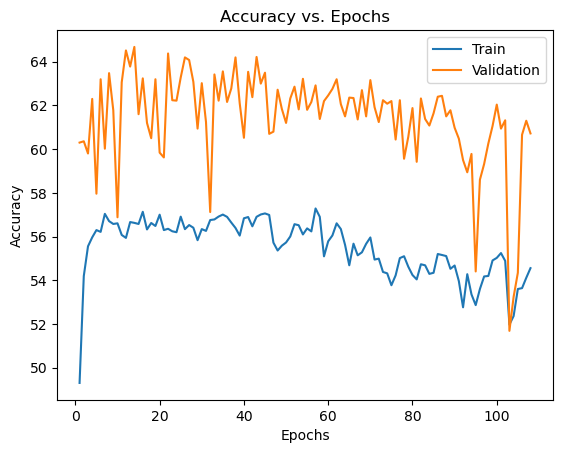

In [13]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_acc",
    y2="valid_acc",
    title="Accuracy vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Accuracy",
)

/home/lippincm/Documents/ML/Interstellar_Analysis/2.MLP_Multi_Classifier/MLP_utils/utils.py:788: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/2.MLP_Multi_Classifier/MLP_utils/utils.py:789: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



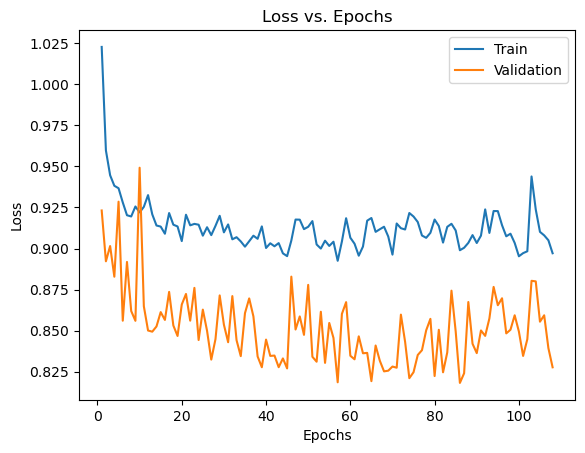

In [14]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
)

In [15]:
# calling the testing function and outputing list values of tested model
y_pred_list = test_optimized_model(
    model, test_loader, IN_FEATURES, OUT_FEATURES, param_dict, params
)
# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.45      0.81      0.57      1346
           1       0.60      0.38      0.46      1768
           2       0.81      0.62      0.70      1891

    accuracy                           0.58      5005
   macro avg       0.62      0.60      0.58      5005
weighted avg       0.64      0.58      0.58      5005

Precision for class 0: 0.44571896763621466
Recall for class 0: 0.8083209509658247
Precision for class 1: 0.5966162065894924
Recall for class 1: 0.37895927601809953
Precision for class 2: 0.8105482303955587
Recall for class 2: 0.6176626123744051


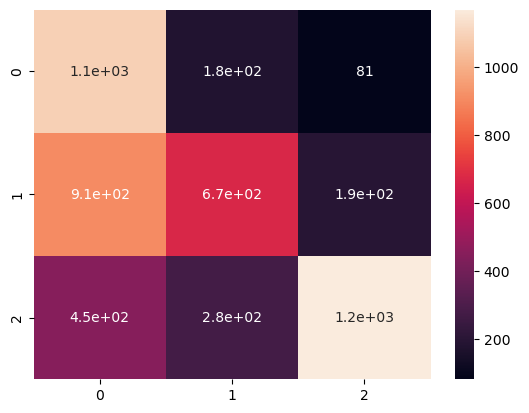

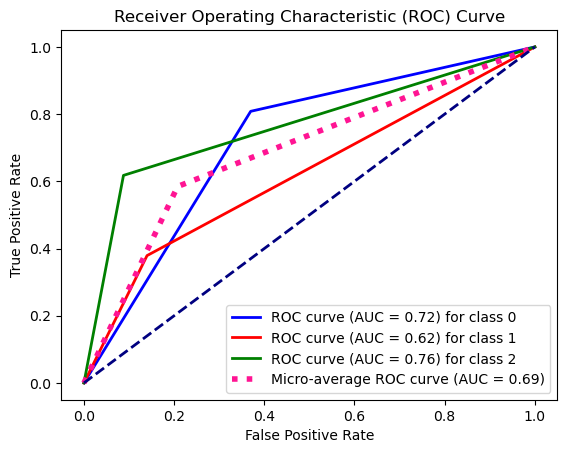

In [16]:
# Call visualization function
results_output(y_pred_list, Y_test, OUT_FEATURES)